# Solving the TSP using Self-Organizing Maps

This is another implemenation for SOM to solve a TSP.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import requests
import os
from tqdm import tqdm

from som_tsp.io_helper import read_tsp, normalize
from som_tsp.neuron import generate_network, get_neighborhood, get_route
from som_tsp.distance import select_closest, route_distance
from som_tsp.plot import plot_network, plot_route

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

### Read TSP data

In [2]:
url = 'https://raw.githubusercontent.com/Optimization-Algorithms-Book/Code-Listings/256207c4a8badc0977286c48a6e1cfd33237a51d/Appendix%20B/data/TSP/'
tsp='qa194.tsp' # TSP instance

response = requests.get(url+tsp)
response.raise_for_status()  # Ensure we got an OK response
problem_text = response.text
with open(tsp, 'w') as file:
    file.write(problem_text)
problem = read_tsp(tsp)

paths_x = []
paths_y = []

# Obtain the normalized set of cities (w/ coord in [0,1])
cities = problem.copy()

cities[['x', 'y']] = normalize(cities[['x', 'y']])

Problem with 194 cities read.


### Create a self-organizing map

In [3]:
# The population size is 8 times the number of cities
n = cities.shape[0] * 8

iterations = 20000
fps = 10
learning_rate=0.8

# Generate an adequate network of neurons:
network = generate_network(n)
print('Network of {} neurons created. Starting the iterations:'.format(n))

Network of 1552 neurons created. Starting the iterations:


### Learning loop

In [4]:
# Store the route lengths in a list
route_lengths = []

for i in tqdm(range(iterations)):
    if not i % 100:
        print('\t> Iteration {}/{}'.format(i, iterations), end="\r")
    # Choose a random city
    city = cities.sample(1)[['x', 'y']].values
    winner_idx = select_closest(network, city)
    
    # Generate a filter that applies changes to the winner's gaussian
    gaussian = get_neighborhood(winner_idx, n // 10, network.shape[0])
    # Update the network's weights (closer to the city)
    network += gaussian[:, np.newaxis] * learning_rate * (city - network)

    if not i % fps:
        paths_x.append(network[:, 0].copy())
        paths_y.append(network[:, 1].copy())

    # Decay the variables
    learning_rate = learning_rate * 0.99997
    n = n * 0.9997

    # Check for plotting interval
    if not i % 1000:
        plot_network(cities, network, name='diagrams/{:05d}.png'.format(i))

    # Check if any parameter has completely decayed.
    if n < 1:
        print('Radius has completely decayed, finishing execution',
              'at {} iterations'.format(i))
        break
    if learning_rate < 0.001:
        print('Learning rate has completely decayed, finishing execution',
              'at {} iterations'.format(i))
        break
    
    # Calculate distance and store in route_lengths list
    route = get_route(cities, network)
    problem = problem.reindex(route)
    distance = route_distance(problem)
    route_lengths.append(distance)

else:
    print('Completed {} iterations.'.format(iterations))

  0%|          | 0/20000 [00:00<?, ?it/s]

  1%|          | 104/20000 [00:03<10:09, 32.63it/s]

  1%|          | 204/20000 [00:06<09:26, 34.96it/s]

  2%|▏         | 304/20000 [00:08<09:36, 34.19it/s]

  2%|▏         | 404/20000 [00:11<09:45, 33.49it/s]

  3%|▎         | 504/20000 [00:14<08:58, 36.22it/s]

  3%|▎         | 604/20000 [00:17<08:46, 36.83it/s]

  4%|▎         | 704/20000 [00:20<13:17, 24.20it/s]

  4%|▍         | 803/20000 [00:23<15:36, 20.50it/s]

  5%|▍         | 905/20000 [00:27<10:14, 31.09it/s]

  5%|▌         | 1002/20000 [00:30<12:02, 26.29it/s]

  6%|▌         | 1106/20000 [00:33<08:42, 36.19it/s]

  6%|▌         | 1205/20000 [00:36<10:26, 30.00it/s]

  7%|▋         | 1305/20000 [00:39<09:50, 31.64it/s]

  7%|▋         | 1404/20000 [00:43<10:33, 29.36it/s]

  8%|▊         | 1506/20000 [00:46<08:48, 35.00it/s]

  8%|▊         | 1605/20000 [00:50<10:49, 28.32it/s]

  9%|▊         | 1704/20000 [00:53<08:32, 35.69it/s]

  9%|▉         | 1808/20000 [00:56<08:15, 36.75it/s]

 10%|▉         | 1904/20000 [00:59<08:59, 33.52it/s]

 10%|█         | 2004/20000 [01:02<08:29, 35.33it/s]

 11%|█         | 2104/20000 [01:04<07:57, 37.49it/s]

 11%|█         | 2204/20000 [01:07<08:22, 35.40it/s]

 12%|█▏        | 2304/20000 [01:10<08:14, 35.77it/s]

 12%|█▏        | 2404/20000 [01:13<08:20, 35.16it/s]

 13%|█▎        | 2504/20000 [01:15<07:52, 36.99it/s]

 13%|█▎        | 2604/20000 [01:18<07:47, 37.20it/s]

 14%|█▎        | 2703/20000 [01:21<08:14, 34.96it/s]

 14%|█▍        | 2804/20000 [01:25<12:36, 22.72it/s]

 15%|█▍        | 2904/20000 [01:27<08:03, 35.37it/s]

 15%|█▌        | 3004/20000 [01:30<08:16, 34.23it/s]

 16%|█▌        | 3108/20000 [01:33<07:31, 37.42it/s]

 16%|█▌        | 3204/20000 [01:36<07:32, 37.08it/s]

 17%|█▋        | 3304/20000 [01:39<07:55, 35.10it/s]

 17%|█▋        | 3404/20000 [01:42<07:33, 36.57it/s]

 18%|█▊        | 3504/20000 [01:44<08:00, 34.36it/s]

 18%|█▊        | 3604/20000 [01:47<07:40, 35.58it/s]

 19%|█▊        | 3705/20000 [01:50<07:31, 36.13it/s]

 19%|█▉        | 3805/20000 [01:53<07:44, 34.89it/s]

 20%|█▉        | 3904/20000 [01:56<09:38, 27.84it/s]

 20%|██        | 4002/20000 [01:59<11:10, 23.87it/s]

 21%|██        | 4106/20000 [02:03<08:48, 30.10it/s]

 21%|██        | 4204/20000 [02:06<10:14, 25.71it/s]

 22%|██▏       | 4305/20000 [02:09<07:35, 34.47it/s]

 22%|██▏       | 4405/20000 [02:12<07:53, 32.91it/s]

 23%|██▎       | 4505/20000 [02:15<07:08, 36.19it/s]

 23%|██▎       | 4605/20000 [02:18<07:17, 35.23it/s]

 24%|██▎       | 4705/20000 [02:21<06:51, 37.15it/s]

 24%|██▍       | 4805/20000 [02:23<06:39, 38.02it/s]

 25%|██▍       | 4905/20000 [02:26<07:20, 34.28it/s]

 25%|██▌       | 5005/20000 [02:29<07:28, 33.42it/s]

 26%|██▌       | 5105/20000 [02:32<06:58, 35.56it/s]

 26%|██▌       | 5205/20000 [02:34<06:54, 35.71it/s]

 27%|██▋       | 5305/20000 [02:37<06:40, 36.67it/s]

 27%|██▋       | 5405/20000 [02:40<07:16, 33.43it/s]

 28%|██▊       | 5505/20000 [02:43<06:35, 36.62it/s]

 28%|██▊       | 5605/20000 [02:45<06:23, 37.49it/s]

 29%|██▊       | 5705/20000 [02:48<06:37, 35.93it/s]

 29%|██▉       | 5805/20000 [02:51<06:31, 36.21it/s]

 30%|██▉       | 5905/20000 [02:54<06:43, 34.96it/s]

 30%|███       | 6005/20000 [02:57<07:14, 32.21it/s]

 31%|███       | 6105/20000 [03:00<07:00, 33.02it/s]

 31%|███       | 6205/20000 [03:03<06:23, 35.95it/s]

 32%|███▏      | 6305/20000 [03:06<06:54, 33.08it/s]

 32%|███▏      | 6405/20000 [03:09<06:31, 34.72it/s]

 33%|███▎      | 6505/20000 [03:11<06:26, 34.90it/s]

 33%|███▎      | 6605/20000 [03:14<07:18, 30.58it/s]

 34%|███▎      | 6705/20000 [03:17<06:46, 32.68it/s]

 34%|███▍      | 6805/20000 [03:20<06:34, 33.48it/s]

 35%|███▍      | 6905/20000 [03:23<06:18, 34.56it/s]

 35%|███▌      | 7005/20000 [03:26<06:23, 33.91it/s]

 36%|███▌      | 7105/20000 [03:29<07:07, 30.14it/s]

 36%|███▌      | 7205/20000 [03:32<06:01, 35.35it/s]

 37%|███▋      | 7305/20000 [03:35<05:44, 36.90it/s]

 37%|███▋      | 7405/20000 [03:37<05:40, 36.98it/s]

 38%|███▊      | 7505/20000 [03:40<05:36, 37.15it/s]

 38%|███▊      | 7605/20000 [03:43<05:32, 37.32it/s]

 39%|███▊      | 7705/20000 [03:46<05:29, 37.27it/s]

 39%|███▉      | 7805/20000 [03:48<05:40, 35.82it/s]

 40%|███▉      | 7905/20000 [03:51<05:55, 34.04it/s]

 40%|████      | 8005/20000 [03:54<05:59, 33.34it/s]

 41%|████      | 8105/20000 [03:57<05:27, 36.37it/s]

 41%|████      | 8205/20000 [04:00<05:40, 34.69it/s]

 42%|████▏     | 8305/20000 [04:03<05:45, 33.84it/s]

 42%|████▏     | 8405/20000 [04:05<05:13, 37.01it/s]

 43%|████▎     | 8505/20000 [04:08<05:15, 36.40it/s]

 43%|████▎     | 8607/20000 [04:11<05:24, 35.15it/s]

 44%|████▎     | 8707/20000 [04:14<05:11, 36.24it/s]

 44%|████▍     | 8803/20000 [04:17<05:46, 32.28it/s]

 45%|████▍     | 8907/20000 [04:20<05:00, 36.87it/s]

 45%|████▌     | 9003/20000 [04:22<05:47, 31.67it/s]

 46%|████▌     | 9105/20000 [04:25<05:04, 35.84it/s]

 46%|████▌     | 9205/20000 [04:28<05:01, 35.80it/s]

 47%|████▋     | 9305/20000 [04:31<05:01, 35.45it/s]

 47%|████▋     | 9405/20000 [04:34<05:04, 34.76it/s]

 48%|████▊     | 9505/20000 [04:37<05:07, 34.08it/s]

 48%|████▊     | 9606/20000 [04:40<05:11, 33.40it/s]

 49%|████▊     | 9706/20000 [04:43<05:06, 33.61it/s]

 49%|████▉     | 9806/20000 [04:46<05:17, 32.09it/s]

 50%|████▉     | 9902/20000 [04:49<05:13, 32.25it/s]

 50%|█████     | 10002/20000 [04:51<05:19, 31.29it/s]

 51%|█████     | 10106/20000 [04:54<04:30, 36.60it/s]

 51%|█████     | 10206/20000 [04:57<04:43, 34.56it/s]

 52%|█████▏    | 10306/20000 [05:00<04:36, 35.10it/s]

 52%|█████▏    | 10406/20000 [05:03<04:36, 34.67it/s]

 53%|█████▎    | 10507/20000 [05:06<04:19, 36.64it/s]

 53%|█████▎    | 10607/20000 [05:09<04:24, 35.46it/s]

 54%|█████▎    | 10703/20000 [05:11<04:32, 34.16it/s]

 54%|█████▍    | 10807/20000 [05:14<04:04, 37.66it/s]

 55%|█████▍    | 10907/20000 [05:17<04:07, 36.69it/s]

 55%|█████▌    | 11003/20000 [05:20<04:35, 32.67it/s]

 56%|█████▌    | 11103/20000 [05:22<04:04, 36.43it/s]

 56%|█████▌    | 11203/20000 [05:25<05:37, 26.04it/s]

 57%|█████▋    | 11307/20000 [05:28<03:49, 37.86it/s]

 57%|█████▋    | 11407/20000 [05:31<03:55, 36.41it/s]

 58%|█████▊    | 11507/20000 [05:34<03:54, 36.17it/s]

 58%|█████▊    | 11607/20000 [05:37<03:49, 36.62it/s]

 59%|█████▊    | 11707/20000 [05:40<03:48, 36.34it/s]

 59%|█████▉    | 11804/20000 [05:42<03:39, 37.37it/s]

 60%|█████▉    | 11904/20000 [05:45<04:16, 31.57it/s]

 60%|██████    | 12004/20000 [05:48<03:48, 34.93it/s]

 61%|██████    | 12104/20000 [05:51<03:39, 36.02it/s]

 61%|██████    | 12205/20000 [05:53<03:43, 34.95it/s]

 62%|██████▏   | 12305/20000 [05:56<03:33, 36.07it/s]

 62%|██████▏   | 12401/20000 [05:59<03:26, 36.79it/s]

 63%|██████▎   | 12505/20000 [06:02<03:32, 35.22it/s]

 63%|██████▎   | 12605/20000 [06:05<03:20, 36.80it/s]

 64%|██████▎   | 12705/20000 [06:07<03:26, 35.36it/s]

 64%|██████▍   | 12806/20000 [06:10<03:18, 36.26it/s]

 65%|██████▍   | 12906/20000 [06:13<03:31, 33.51it/s]

 65%|██████▌   | 13002/20000 [06:16<03:44, 31.16it/s]

 66%|██████▌   | 13106/20000 [06:19<03:16, 35.09it/s]

 66%|██████▌   | 13206/20000 [06:22<03:10, 35.60it/s]

 67%|██████▋   | 13306/20000 [06:25<03:19, 33.63it/s]

 67%|██████▋   | 13406/20000 [06:28<03:14, 33.93it/s]

 68%|██████▊   | 13506/20000 [06:31<03:01, 35.82it/s]

 68%|██████▊   | 13604/20000 [06:34<03:06, 34.29it/s]

 69%|██████▊   | 13704/20000 [06:37<03:11, 32.80it/s]

 69%|██████▉   | 13804/20000 [06:40<03:40, 28.16it/s]

 70%|██████▉   | 13906/20000 [06:43<03:01, 33.65it/s]

 70%|███████   | 14002/20000 [06:46<03:57, 25.26it/s]

 71%|███████   | 14105/20000 [06:50<02:45, 35.60it/s]

 71%|███████   | 14205/20000 [06:52<02:34, 37.47it/s]

 72%|███████▏  | 14305/20000 [06:55<02:37, 36.25it/s]

 72%|███████▏  | 14405/20000 [06:58<02:34, 36.31it/s]

 73%|███████▎  | 14505/20000 [07:01<02:30, 36.53it/s]

 73%|███████▎  | 14605/20000 [07:04<02:30, 35.75it/s]

 74%|███████▎  | 14705/20000 [07:06<02:26, 36.08it/s]

 74%|███████▍  | 14805/20000 [07:09<02:24, 35.90it/s]

 75%|███████▍  | 14905/20000 [07:12<02:24, 35.27it/s]

 75%|███████▌  | 15005/20000 [07:15<02:26, 33.98it/s]

 76%|███████▌  | 15105/20000 [07:18<02:23, 34.08it/s]

 76%|███████▌  | 15205/20000 [07:20<02:12, 36.15it/s]

 77%|███████▋  | 15305/20000 [07:23<02:24, 32.52it/s]

 77%|███████▋  | 15405/20000 [07:26<02:06, 36.37it/s]

 78%|███████▊  | 15505/20000 [07:29<02:03, 36.29it/s]

 78%|███████▊  | 15605/20000 [07:31<02:03, 35.70it/s]

 79%|███████▊  | 15705/20000 [07:34<02:01, 35.26it/s]

 79%|███████▉  | 15805/20000 [07:37<01:55, 36.29it/s]

 80%|███████▉  | 15905/20000 [07:40<01:52, 36.48it/s]

 80%|████████  | 16005/20000 [07:43<02:00, 33.16it/s]

 81%|████████  | 16105/20000 [07:45<01:47, 36.23it/s]

 81%|████████  | 16205/20000 [07:48<01:45, 36.02it/s]

 82%|████████▏ | 16305/20000 [07:51<01:42, 35.93it/s]

 82%|████████▏ | 16405/20000 [07:54<01:35, 37.58it/s]

 83%|████████▎ | 16505/20000 [07:57<01:36, 36.18it/s]

 83%|████████▎ | 16605/20000 [07:59<01:30, 37.63it/s]

 84%|████████▎ | 16705/20000 [08:02<01:31, 36.05it/s]

 84%|████████▍ | 16805/20000 [08:05<01:27, 36.45it/s]

 85%|████████▍ | 16905/20000 [08:08<01:30, 34.38it/s]

 85%|████████▌ | 17005/20000 [08:10<01:28, 33.83it/s]

 86%|████████▌ | 17105/20000 [08:13<01:19, 36.25it/s]

 86%|████████▌ | 17205/20000 [08:16<01:20, 34.66it/s]

 87%|████████▋ | 17305/20000 [08:19<01:14, 36.08it/s]

 87%|████████▋ | 17405/20000 [08:22<01:13, 35.18it/s]

 88%|████████▊ | 17505/20000 [08:25<01:14, 33.63it/s]

 88%|████████▊ | 17603/20000 [08:28<01:15, 31.57it/s]

 89%|████████▊ | 17703/20000 [08:31<01:03, 35.90it/s]

 89%|████████▉ | 17803/20000 [08:34<01:10, 31.10it/s]

 90%|████████▉ | 17907/20000 [08:37<00:58, 35.99it/s]

 90%|████████▉ | 17999/20000 [08:39<00:56, 35.46it/s]

 91%|█████████ | 18107/20000 [08:43<00:52, 35.94it/s]

 91%|█████████ | 18207/20000 [08:45<00:49, 36.14it/s]

 92%|█████████▏| 18307/20000 [08:48<00:46, 36.77it/s]

 92%|█████████▏| 18407/20000 [08:51<00:43, 36.46it/s]

 93%|█████████▎| 18503/20000 [08:54<00:43, 34.77it/s]

 93%|█████████▎| 18607/20000 [08:57<00:36, 37.70it/s]

 94%|█████████▎| 18703/20000 [08:59<00:34, 37.08it/s]

 94%|█████████▍| 18803/20000 [09:02<00:34, 35.11it/s]

 95%|█████████▍| 18903/20000 [09:05<00:30, 35.74it/s]

 95%|█████████▌| 19003/20000 [09:08<00:38, 25.80it/s]

 96%|█████████▌| 19108/20000 [09:11<00:23, 37.70it/s]

 96%|█████████▌| 19205/20000 [09:14<00:24, 32.50it/s]

 97%|█████████▋| 19306/20000 [09:18<00:19, 35.49it/s]

 97%|█████████▋| 19406/20000 [09:21<00:16, 35.07it/s]

 98%|█████████▊| 19506/20000 [09:24<00:14, 34.59it/s]

 98%|█████████▊| 19606/20000 [09:26<00:11, 35.66it/s]

 99%|█████████▊| 19706/20000 [09:29<00:08, 35.56it/s]

 99%|█████████▉| 19806/20000 [09:32<00:05, 33.83it/s]

100%|█████████▉| 19906/20000 [09:35<00:02, 35.61it/s]

100%|██████████| 20000/20000 [09:38<00:00, 34.58it/s]

Completed 20000 iterations.


### Plot the route length per iteration

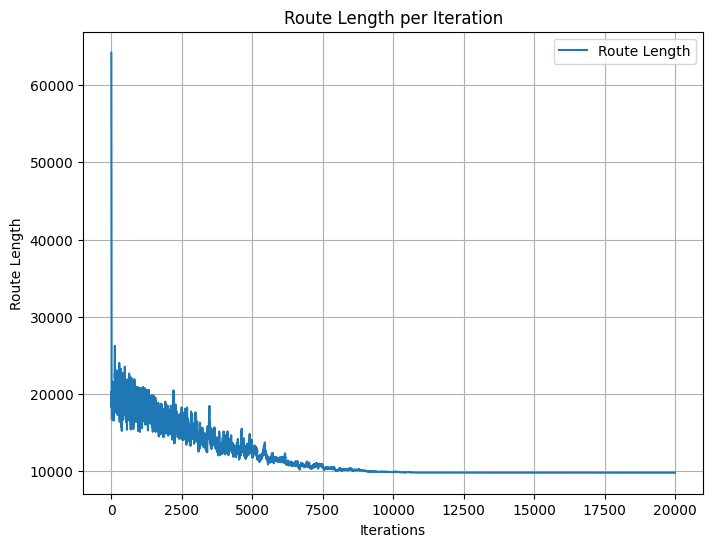

In [5]:
plt.figure(figsize=(8, 6))
plt.plot(range(len(route_lengths)), route_lengths, label='Route Length')
plt.xlabel('Iterations')
plt.ylabel('Route Length')
plt.title('Route Length per Iteration')
plt.grid(True)
plt.legend()
plt.show()

### Plot the route and its length

In [6]:
os.makedirs('diagrams', exist_ok=True)

plot_network(cities, network, name='diagrams/final.png')

route = get_route(cities, network)
plot_route(cities, route, 'diagrams/route.png')

problem = problem.reindex(route)
distance = route_distance(problem)

### Display the route image with its length

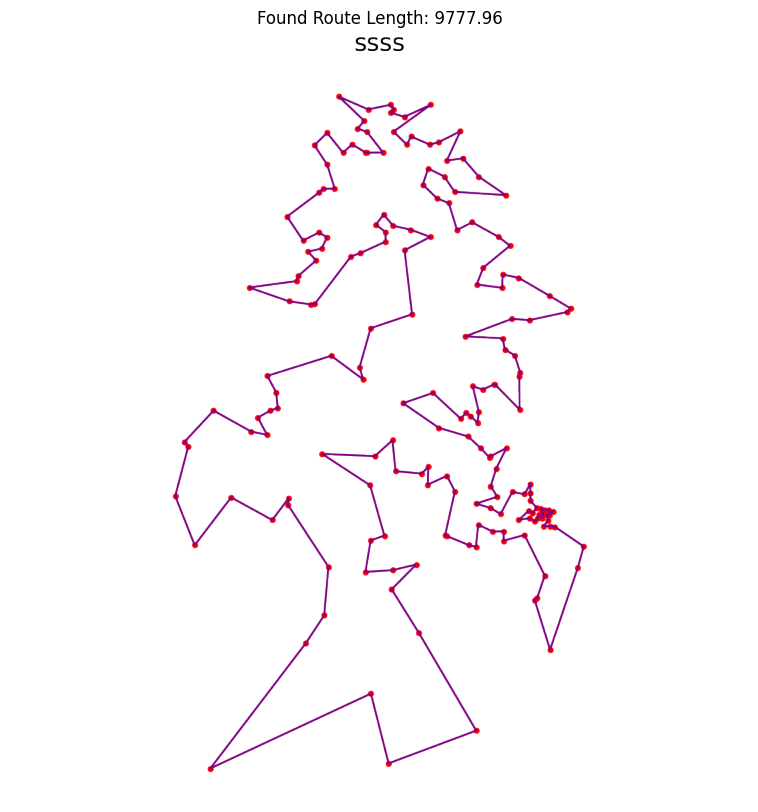

In [7]:
route_image_path = 'diagrams/route.png'
route_image = plt.imread(route_image_path)

plt.figure(figsize=(10, 10))
plt.imshow(route_image)
plt.axis('off')
plt.title('Found Route Length: {:.2f}'.format(distance))
plt.show()

### Create an animation for the search process

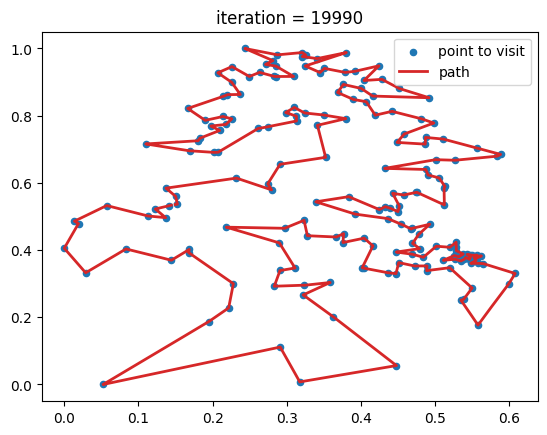

In [8]:
cities = problem.copy()
cities[['x', 'y']] = normalize(cities[['x', 'y']])
fig, ax = plt.subplots()

plt.scatter(cities['x'], cities['y'], label='point to visit', s=20)
ln, = plt.plot([], [], 'C3', linewidth=2, label='path')
plt.legend()

def update(frame):
    ln.set_data(paths_x[frame], paths_y[frame])
    plt.title('iteration = %d' % (frame*fps))
    return ln,

ani = FuncAnimation(fig, update, frames=np.arange(iterations//fps),interval=10, repeat=False, blit=True)
HTML(ani.to_html5_video())